# PII Detection and Redaction for setting compliance and control

In this , we will be performing extracting the text from the documents using AWS Textract and then use Comprehend to perform pii detection. Then we will be using python function to redact that portion of the image. 
Here is conceptual architectural flow:

![alt-text](piiredact.png)

You can automate the entire end to end flow using step function and lambda for orchestration.

We will walk you through following steps:

## Step 1: Setup and install libraries 
## Step 2: Extract text from sample document
## Step 3: Save the extracted text into text/csv file and uplaod to Amazon S3 bucket
## Step 4: Check for PII using Amazon Comprehend Detect PII Sync API.
## Step 5: Mask PII using Amazon Comprehend PII Analysis Job
## Step 6: View the redacted/masked output in Amazon S3 Bucket


# Lets start with Step 1: Setup and install libraries

import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [2]:
!pip install amazon-textract-response-parser

In [3]:
import pandas as pd
import webbrowser, os
import json
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [4]:

region = boto3.Session().region_name

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

prefix = "pii-detection-redaction"
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)
# Customize to your bucket where you have stored the data
print(bucket_path)

https://s3-us-east-1.amazonaws.com/sagemaker-us-east-1-186389221476


# Step 2: Extract text from sample document¶

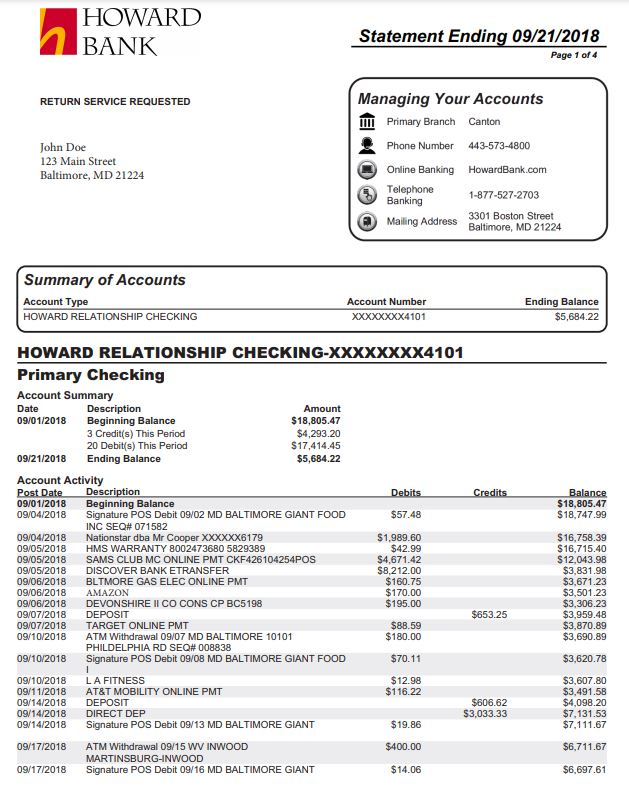

In [5]:
# Document
documentName = "bankstatement.JPG"

display(Image(filename=documentName))

In [6]:
client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
response = client.detect_document_text(Document={'Bytes': bytes_test})


Image loaded bankstatement.JPG


In [7]:
#Extract key values
# Iterate over elements in the document
from trp import Document


doc = Document(response)
page_string = ''
for page in doc.pages:
    # Print lines and words
       
        for line in page.lines:
            #print((line.text))
            page_string += str(line.text)
print(page_string)

HOWARDBANKStatement Ending 09/21/2018Page 1 of 4RETURN SERVICE REQUESTEDManaging Your AccountsIIIIPrimary Branch CantonJohn DoePhone Number 443-573-4800123 Main StreetBaltimore, MD 21224Online Banking HowardBank.com5Telephone1-877-527-2703Bankinga3301 Boston StreetMailing AddressBaltimore, MD 21224Summary of AccountsAccount TypeAccount NumberEnding BalanceHOWARD RELATIONSHIP CHECKINGXXXXXXXX4101$5,684.22HOWARD RELATIONSHIPPrimary CheckingAccount SummaryDateDescriptionAmount09/01/2018Beginning Balance$18,805.473 Credit(s) This Period$4,293.2020 Debit(s) This Period$17,414.4509/21/2018Ending Balance$5,684.22Account ActivityPost DateDescriptionDebitsCreditsBalance09/01/2018Beginning Balance$18,805.4709/04/2018Signature POS Debit 09/02 MD BALTIMORE GIANT FOOD$57.48$18,747.99INC SEQ# 07158209/04/2018Nationstar dba Mr Cooper XXXXXX6179$1,989.60$16,758.3909/05/2018HMS WARRANTY 8002473680 5829389$42.99$16,715.4009/05/2018SAMS CLUB MC ONLINE PMT CKF426104254POS$4,671.42$12,043.9809/05/2018DISCO

# Step 3: Save the extracted text into text/csv file and uplaod to Amazon S3 bucket¶

In [13]:
# Lets get the  data into a text file
text_filename = 'pii_data.txt'
doc = Document(response)
with open(text_filename, 'w', encoding='utf-8') as f:
    for page in doc.pages:
    # Print lines and words
        page_string = ''
        for line in page.lines:
            #print((line.text))
            page_string += str(line.text)
        #print(page_string)
        f.writelines(page_string + "\n")

In [14]:
# Load the documents locally for later analysis
with open(text_filename, "r") as fi:
    raw_texts = [line.strip() for line in fi.readlines()]

In [15]:
import boto3

s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file("pii_data.txt", "pii-detection-redaction/pii_data.txt")

# Step 4: Check for PII using Amazon Comprehend Detect PII Sync API

In [16]:
comprehend = boto3.client(service_name='comprehend')

In [17]:
# Call Amazon Comprehend   and pass it the aggregated text from our   image.

piilist=comprehend.detect_pii_entities(Text = page_string, LanguageCode='en')
redacted_box_color='red'
dpi = 72
pii_detection_threshold = 0.00
print ('Finding PII text...')
not_redacted=0
redacted=0
for pii in piilist['Entities']:
    print(pii['Type'])
    if pii['Score'] > pii_detection_threshold:
                    print ("detected as type '"+pii['Type']+"' and will be redacted.")
                    redacted+=1
                
    else:
        print (" was detected as type '"+pii['Type']+"', but did not meet the confidence score threshold and will not be redacted.")
        not_redacted+=1


print ("Found", redacted, "text boxes to redact.")
print (not_redacted, "additional text boxes were detected, but did not meet the confidence score threshold.")

Finding PII text...
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
NAME
detected as type 'NAME' and will be redacted.
PHONE
detected as type 'PHONE' and will be redacted.
ADDRESS
detected as type 'ADDRESS' and will be redacted.
PHONE
detected as type 'PHONE' and will be redacted.
ADDRESS
detected as type 'ADDRESS' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
DATE_TIME
detected as type 'DATE_TIME'

# Step 5: Mask PII using Amazon Comprehend PII Analysis Job

We will use StartPiiEntitiesDetectionJob API

StartPiiEntitiesDetectionJob API starts an asynchronous PII entity detection job for a collection of documents.

We would be using this API to perform pii detection and redaction for pii_data.txt which we had inspected above.


In [18]:
import uuid
InputS3URI= "s3://"+bucket+ "/pii-detection-redaction/pii_data.txt"
print(InputS3URI)
OutputS3URI="s3://"+bucket+"/pii-detection-redaction"
print(OutputS3URI)
job_uuid = uuid.uuid1()
job_name = f"pii-job-{job_uuid}"

s3://sagemaker-us-east-1-186389221476/pii-detection-redaction/pii_data.txt
s3://sagemaker-us-east-1-186389221476/pii-detection-redaction


In [19]:

response = comprehend.start_pii_entities_detection_job(
    InputDataConfig={
        'S3Uri': InputS3URI,
        'InputFormat': 'ONE_DOC_PER_FILE'
    },
    OutputDataConfig={
        'S3Uri': OutputS3URI
       
    },
    Mode='ONLY_REDACTION',
    RedactionConfig={
        'PiiEntityTypes': [
           'ALL',
        ],
        'MaskMode': 'MASK',
        'MaskCharacter': '*'
    },
    DataAccessRoleArn = role,
    JobName=job_name,
    LanguageCode='en',
    
)

In [20]:
# Get the job ID
events_job_id = response['JobId']
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)

{'PiiEntitiesDetectionJobProperties': {'JobId': '03c308e8e9743f188cd16b88d898cd5e', 'JobArn': 'arn:aws:comprehend:us-east-1:186389221476:pii-entities-detection-job/03c308e8e9743f188cd16b88d898cd5e', 'JobName': 'pii-job-fa977a0c-22ea-11ec-8fc2-06c3864a6c5f', 'JobStatus': 'SUBMITTED', 'SubmitTime': datetime.datetime(2021, 10, 1, 19, 8, 43, 843000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-186389221476/pii-detection-redaction/pii_data.txt', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-186389221476/pii-detection-redaction/186389221476-PII-03c308e8e9743f188cd16b88d898cd5e/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::186389221476:role/ComprehendEventsBlog-SageMakerRole-1PKY0AT53UQJ4', 'Mode': 'ONLY_REDACTION'}, 'ResponseMetadata': {'RequestId': '3c2cb481-352d-49ff-b037-8c8ea8c3ed6a', 'HTTPStatusCode': 2

# The job will take roughly 6-7 minutes. The below code is to check the status of the job. The cell execution would be completed after the job is completed


In [21]:
from time import sleep
# Get current job status
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)
# Loop until job is completed
waited = 0
timeout_minutes = 10
while job['PiiEntitiesDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)

{'PiiEntitiesDetectionJobProperties': {'JobId': '03c308e8e9743f188cd16b88d898cd5e', 'JobArn': 'arn:aws:comprehend:us-east-1:186389221476:pii-entities-detection-job/03c308e8e9743f188cd16b88d898cd5e', 'JobName': 'pii-job-fa977a0c-22ea-11ec-8fc2-06c3864a6c5f', 'JobStatus': 'IN_PROGRESS', 'SubmitTime': datetime.datetime(2021, 10, 1, 19, 8, 43, 843000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-186389221476/pii-detection-redaction/pii_data.txt', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-186389221476/pii-detection-redaction/186389221476-PII-03c308e8e9743f188cd16b88d898cd5e/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::186389221476:role/ComprehendEventsBlog-SageMakerRole-1PKY0AT53UQJ4', 'Mode': 'ONLY_REDACTION'}, 'ResponseMetadata': {'RequestId': '3ced4a76-fc71-42ac-bdba-385e3efd8a91', 'HTTPStatusCode':

In [22]:
print(response)

{'JobId': '03c308e8e9743f188cd16b88d898cd5e', 'JobArn': 'arn:aws:comprehend:us-east-1:186389221476:pii-entities-detection-job/03c308e8e9743f188cd16b88d898cd5e', 'JobStatus': 'SUBMITTED', 'ResponseMetadata': {'RequestId': '820403b6-c17f-4c42-a5d9-bd6fda43cc70', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '820403b6-c17f-4c42-a5d9-bd6fda43cc70', 'content-type': 'application/x-amz-json-1.1', 'content-length': '181', 'date': 'Fri, 01 Oct 2021 19:08:43 GMT'}, 'RetryAttempts': 0}}


# Step 6: View the redacted/masked output in Amazon S3 Bucket¶

In [23]:
filename="pii_data.txt"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
print(output_data_s3_file)

s3://sagemaker-us-east-1-186389221476/pii-detection-redaction/186389221476-PII-03c308e8e9743f188cd16b88d898cd5e/output/pii_data.txt.out


In [25]:

# The output filename is the input filename + ".out"
s3_client = boto3.client(service_name='s3')
filename="pii_data.txt"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
print(output_data_s3_file)
output_data_s3_filepath=output_data_s3_file.split("//")[1].split("/")[1]+"/"+output_data_s3_file.split("//")[1].split("/")[2]+"/"+output_data_s3_file.split("//")[1].split("/")[3]+"/"+output_data_s3_file.split("//")[1].split("/")[4]
print(output_data_s3_filepath)

f = BytesIO()
s3_client.download_fileobj(bucket, output_data_s3_filepath, f)
f.seek(0)
print(f.getvalue())

s3://sagemaker-us-east-1-186389221476/pii-detection-redaction/186389221476-PII-03c308e8e9743f188cd16b88d898cd5e/output/pii_data.txt.out
pii-detection-redaction/186389221476-PII-03c308e8e9743f188cd16b88d898cd5e/output/pii_data.txt.out
b'HOWARDBANKStatement Ending ************** 1 of 4RETURN SERVICE REQUESTEDManaging Your AccountsIIIIPrimary Branch ********** DoePhone Number *************** **** StreetBaltimore, MD 21224Online Banking HowardBank.com5Telephone**************Bankinga3301 ****** StreetMailing AddressBaltimore, MD 21224Summary of AccountsAccount TypeAccount NumberEnding BalanceHOWARD RELATIONSHIP CHECKINGXXXXXXXX4101$5,684.22HOWARD RELATIONSHIPPrimary CheckingAccount SummaryDateDescriptionAmount09***************** Balance$18,805.473 Credit(s) This Period$4,293.2020 Debit(s) This Period$17,414.4509************** Balance$5,684.22Account ActivityPost DateDescriptionDebitsCreditsBalance09***************** Balance$18,805.4709***************** POS Debit ***** MD BALTIMORE GIANT FOO